# pygam performance
* rmse = ?
* r2 = ?

# Load module

In [339]:
import sys
sys.path.append("../../../utils/")

import utils

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_val_predict
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import joblib
import math
import os
import glob

print(os.listdir("../../../data/house"))
print(glob.glob('*.pkl'))

['ames_shallow_fe.pickle', 'ames.pickle', 'ames_shallow_fe_indexers.pickle', 'descriptions.pickle', 'ames.csv', 'description.txt']
[]


# Load data

In [29]:
filename = '../../../data/house/ames_shallow_fe.pickle'
df = joblib.load(filename)
df.head(3)

p_i_d  area   price m_s_sub_class  m_s_zoning  lot_frontage  lot_area  \
0  526350040   896  105000            20           0          80.0     11622   
1  526351010  1329  172000            20           1          81.0     14267   
2  526353030  2110  244000            20           1          93.0     11160   

   lot_shape  land_contour  lot_config  ...  pool_area  fence  misc_feature  \
0          0             0           0  ...          0      0             0   
1          1             0           1  ...          0      1             1   
2          0             0           1  ...          0      1             0   

   misc_val  mo_sold  yr_sold  sale_type  sale_condition  log_price  total_s_f  
0         0        6     2010          0               0  11.561725     1778.0  
1     12500        6     2010          0               0  12.055256     2658.0  
2         0        4     2010          0               0  12.404928     4220.0  

[3 rows x 79 columns]

In [30]:
# EBM 은  NA를 용납하지 않는다...
df = df.dropna()
df.shape

(2885, 79)

# EBM modeling

In [31]:
# interpretml EBM
from interpret.glassbox import ExplainableBoostingRegressor, LinearRegression, RegressionTree
from interpret.data import Marginal
from interpret import show

In [32]:
X = df.drop(['p_i_d','price','log_price'], axis=1)
X.head(3)

area m_s_sub_class  m_s_zoning  lot_frontage  lot_area  lot_shape  \
0   896            20           0          80.0     11622          0   
1  1329            20           1          81.0     14267          1   
2  2110            20           1          93.0     11160          0   

   land_contour  lot_config  land_slope  neighborhood  ...  screen_porch  \
0             0           0           0             0  ...           120   
1             0           1           0             0  ...             0   
2             0           1           0             0  ...             0   

   pool_area  fence  misc_feature  misc_val  mo_sold  yr_sold  sale_type  \
0          0      0             0         0        6     2010          0   
1          0      1             1     12500        6     2010          0   
2          0      1             0         0        4     2010          0   

   sale_condition  total_s_f  
0               0     1778.0  
1               0     2658.0  
2               0     4220.0  

[3 rows x 76 columns]

In [33]:
y = df['price']

In [34]:
ebm = ExplainableBoostingRegressor(random_state=42)
ebm.fit(X, y)

ExplainableBoostingRegressor(feature_names=['area', 'm_s_sub_class',
                                            'm_s_zoning', 'lot_frontage',
                                            'lot_area', 'lot_shape',
                                            'land_contour', 'lot_config',
                                            'land_slope', 'neighborhood',
                                            'condition1', 'condition2',
                                            'bldg_type', 'house_style',
                                            'overall_qual', 'overall_cond',
                                            'year_built', 'year_remod_add',
                                            'roof_style', 'roof_matl',
                                            'exterior1st', 'exterior2nd',
                                            'mas_vnr_ty...
                                            'continuous', 'continuous',
                                            'continuous', 'continuou

# pyGAM modeling

In [12]:
# interpretml EBM
from pygam import LinearGAM, s, f

In [44]:
# X_np = X[['area','overall_qual','bsmt_fin_s_f1']].to_numpy().setflags(write=True)

In [53]:
# X_np = X[['area','overall_qual','bsmt_fin_s_f1']].to_numpy()
X_np=X.to_numpy()

In [36]:
# y_np = y.to_numpy().setflags(write=True)

In [49]:
y_np = y.to_numpy()

In [58]:
def intersperse(lst, item):
    result = [item] * (len(lst) * 2 - 1)
    result[0::2] = lst
    return result

In [89]:
# X_np=X[["area","lot_frontage","lot_area"]].to_numpy()

In [120]:
# reorder columns by their datatypes
# put categorical variables to the end of the table
X=X.loc[:,X.dtypes.sort_values().index]

In [140]:
X_np=X.to_numpy()

In [121]:
num_cate_cols=X.dtypes[X.dtypes=="object"].shape[0]

In [259]:
num_features=X.shape[1]
statement_list=[f"s({i})+" if i!=num_features-num_cate_cols-1 else f"s({i})" for i in range(num_features-num_cate_cols)]
statement_list_cate=["+"]+[f"f({i})+" if i!=num_features-1 else f"f({i})" for i in range(num_features-num_cate_cols,num_features)]

In [389]:
from pygam import intercept 


def pygam_statement(num_featuresL: int,
                    num_cate_features: int,
                    cate_include:bool = False):
    
    '''
    Return pygam statement which is used as an input for pyGAM instance.
    Put in number of features(num_features) and number of categorical features(num_cate_features), and specify whether you would include categorical features or not.
    Please note that num_features argument should be larger than num_cate_features argument.
    
    
    [Usage]
    
    > pygam_statement(6, 3, True)
    >> s(0) + s(1) + s(2) + f(3) + f(4) + f(5)
    
    > gam=LinearGAM(statement)
    > gam.fit(X, y)
    >> LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, 
   terms=s(0) + s(1) + s(2) + f(3) + f(4) + f(5) + intercept,
   tol=0.0001, verbose=False)
    
    '''
    
    
    
    statement_list=[f"s({i})+" if i!=num_features-num_cate_features-1 else f"s({i})" for i in range(num_features-num_cate_features)]

    # if argument for categorical features is True, create statement list for categorical features and append it to the end of original list
    if cate_include:
        statement_list_cate=["+"]+[f"f({i})+" if i!=num_features-1 else f"f({i})" for i in range(num_features-num_cate_features,num_features)]
        statement_list=statement_list+statement_list_cate
        statement=eval("".join(statement_list))
    
    else:   
        statement=eval("".join(statement_list))
        
    return statement + intercept

In [453]:
statement=pygam_statement(76, 3, True)

In [445]:
gam=LinearGAM(statement)

In [446]:
X_np=X.iloc[:,:73].to_numpy()

In [447]:
gam.fit(X_np, y_np)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, 
   terms=s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11) + s(12) + s(13) + s(14) + s(15) + s(16) + s(17) + s(18) + s(19) + s(20) + s(21) + s(22) + s(23) + s(24) + s(25) + s(26) + s(27) + s(28) + s(29) + s(30) + s(31) + s(32) + s(33) + s(34) + s(35) + s(36) + s(37) + s(38) + s(39) + s(40) + s(41) + s(42) + s(43) + s(44) + s(45) + s(46) + s(47) + s(48) + s(49) + s(50) + s(51) + s(52) + s(53) + s(54) + s(55) + s(56) + s(57) + s(58) + s(59) + s(60) + s(61) + s(62) + s(63) + s(64) + s(65) + s(66) + s(67) + s(68) + s(69) + s(70) + s(71) + s(72) + intercept,
   tol=0.0001, verbose=False)

In [448]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    473.5004
Link Function:                     IdentityLink Log Likelihood:                                -58896.0952
Number of Samples:                         2885 AIC:                                           118741.1913
                                                AICc:                                           118928.471
                                                GCV:                                        412819652.9398
                                                Scale:                                      292991023.5425
                                                Pseudo R-Squared:                                   0.9606
Feature Function                  Lam

/Users/a420777/opt/anaconda3/envs/whatif/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning:

KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 




In [449]:
def pygam_feature_plot(plot_shape: tuple,
                       pygam_model,
                       X_colnames: list or pd.Series) -> None:
    
    '''
    Plot partial dependence plot for each feature. 
    The number of plots will be (plot_shape[0]*plot_shape[1]), from column number 0 to column number (plot_shape[0]*plot_shape[1]).
    
    As inputs, specify shape of plots you want to display and fitted pygam model.
    To provide titles to the plots, put in feature name list from the train dataset.
    
    
    [Usage]
    > pygam_feature_plot((5,5), gam, X.columns)
    
    
    '''
    
    plot_shape_y=plot_shape[0]
    plot_shape_x=plot_shape[1]
    
    ## plotting
    plt.figure(figsize=(100,40));

    fig, axs = plt.subplots(plot_shape_y,plot_shape_x, constrained_layout=False, figsize=(24,13.5));
    plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.5, hspace=0.5)

    # X_colnames = X.columns.tolist()

    for num, ax in enumerate(axs):
        for j in range(plot_shape_x):
            
            chart_num=num*plot_shape_x+j

            XX = pygam_model.generate_X_grid(term=chart_num)
            ax[j].plot(XX[:, chart_num], pygam_model.partial_dependence(term=chart_num, X=XX))
            ax[j].plot(XX[:, chart_num], pygam_model.partial_dependence(term=chart_num, X=XX, width=.95)[1], c='r', ls='--')
            if chart_num == 0:
                ax[j].set_ylim(-1000,1000)
            ax[j].set_title(X_colnames[chart_num])
            ax[j].set_ylim([-50000,50000])
            
    return Nonesa

<Figure size 7200x2880 with 0 Axes>

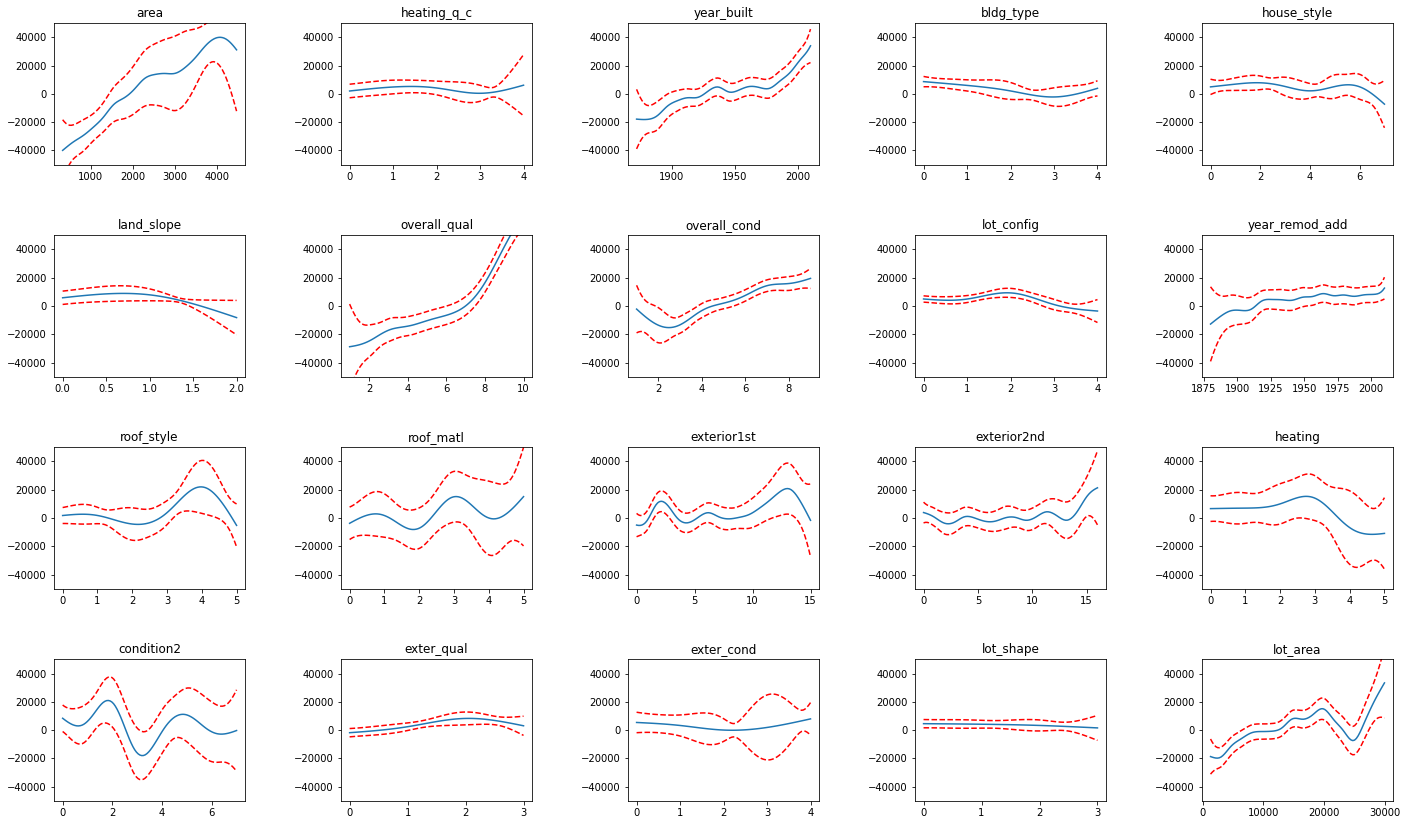

In [455]:
pygam_feature_plot((4,5), gam, X.columns)

In [396]:
plot_shape=(8,10)
pygam_model=gam
X_colnames=X.columns

In [399]:
intercept_=pygam_model.coef_[-1]

In [400]:
chart_num

73

In [409]:
pygam_model.coef_[-1]

69249.88849883815

In [421]:
pygam_model.statistics_["m_features"]

76

In [459]:
X.shape

(2885, 76)

In [458]:
X.describe()

area  heating_q_c   year_built    bldg_type  house_style  \
count  2885.000000  2885.000000  2885.000000  2885.000000  2885.000000   
mean   1489.643674     0.933795  1971.441594     0.343154     0.875563   
std     487.234752     0.765581    30.296532     0.873456     1.225357   
min     334.000000     0.000000  1872.000000     0.000000     0.000000   
25%    1120.000000     0.000000  1954.000000     0.000000     0.000000   
50%    1436.000000     1.000000  1974.000000     0.000000     0.000000   
75%    1737.000000     1.000000  2001.000000     0.000000     1.000000   
max    4476.000000     4.000000  2010.000000     4.000000     7.000000   

        land_slope  overall_qual  overall_cond   lot_config  year_remod_add  \
count  2885.000000   2885.000000   2885.000000  2885.000000     2885.000000   
mean      0.046447      6.092894      5.571231     0.398267     1981.816984   
std       0.224825      1.402532      1.107379     0.766721       26.013928   
min       0.000000      1.000000      1.000000     0.000000     1880.000000   
25%       0.000000      5.000000      5.000000     0.000000     1965.000000   
50%       0.000000      6.000000      5.000000     0.000000     1993.000000   
75%       0.000000      7.000000      6.000000     1.000000     2004.000000   
max       2.000000     10.000000      9.000000     4.000000     2010.000000   

       ...  garage_area  total_bsmt_s_f  bsmt_fin_s_f1  bsmt_full_bath  \
count  ...  2885.000000     2885.000000    2885.000000     2885.000000   
mean   ...   470.101560     1043.924090     434.901560        0.426343   
std    ...   213.221466      419.062568     436.384712        0.521918   
min    ...     0.000000        0.000000       0.000000        0.000000   
25%    ...   319.000000      791.000000       0.000000        0.000000   
50%    ...   478.000000      988.000000     368.000000        0.000000   
75%    ...   576.000000     1288.000000     729.000000        1.000000   
max    ...  1488.000000     3206.000000    2288.000000        3.000000   

       bsmt_fin_s_f2  mas_vnr_area  garage_cars  bsmt_unf_s_f  lot_frontage  \
count    2885.000000   2885.000000  2885.000000   2885.000000   2885.000000   
mean       49.156672     99.367071     1.759792    559.865858     68.996707   
std       167.605542    173.982868     0.760624    438.772088     20.278930   
min         0.000000      0.000000     0.000000      0.000000     21.000000   
25%         0.000000      0.000000     1.000000    220.000000     60.000000   
50%         0.000000      0.000000     2.000000    466.000000     70.000000   
75%         0.000000    162.000000     2.000000    801.000000     80.000000   
max      1526.000000   1600.000000     5.000000   2336.000000    182.000000   

       bsmt_half_bath  
count     2885.000000  
mean         0.060659  
std          0.244485  
min          0.000000  
25%          0.000000  
50%          0.000000  
75%          0.000000  
max          2.000000  

[8 rows x 73 columns]

ValueError: cannot create grid for intercept term

<Figure size 7200x2880 with 0 Axes>

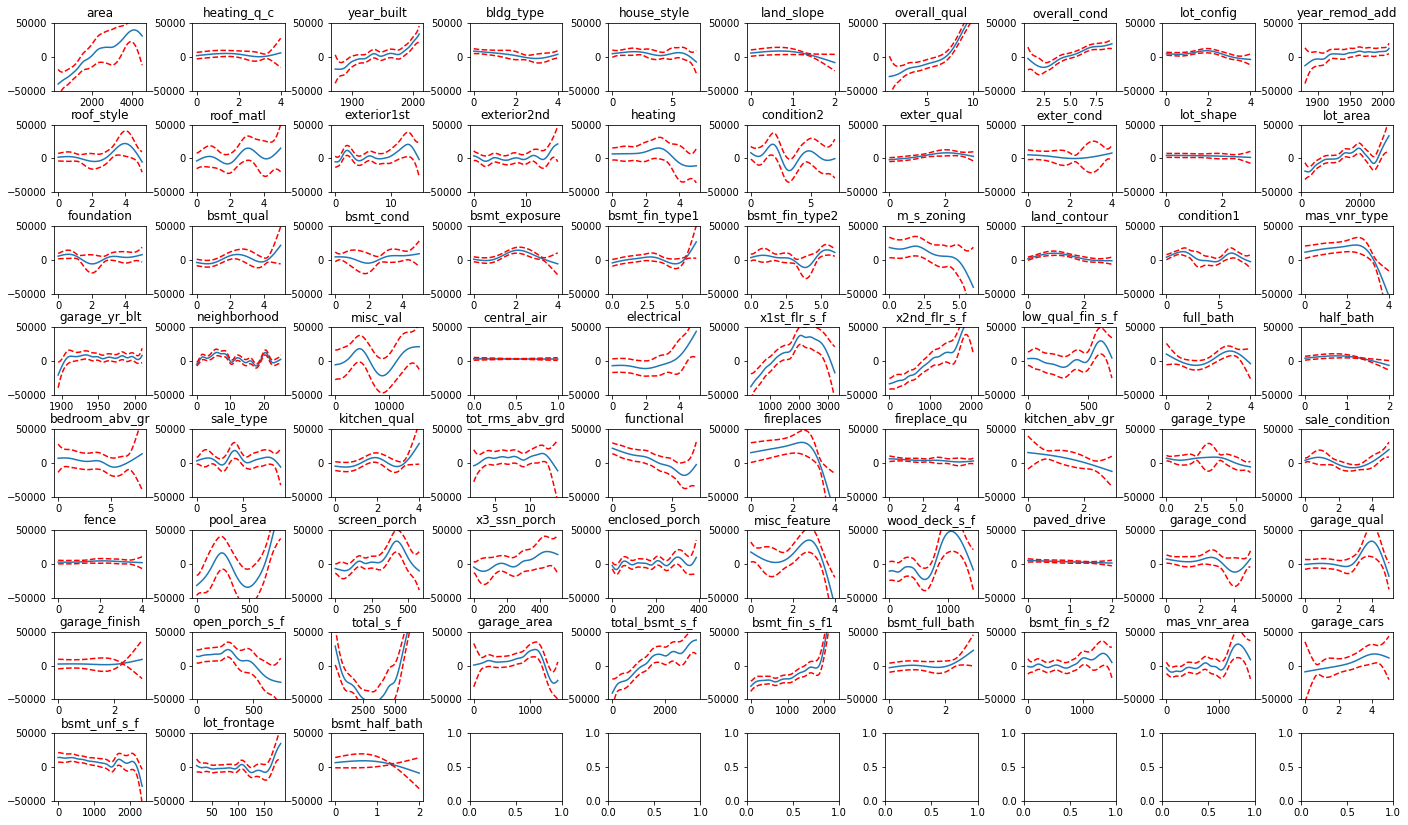

In [397]:
plot_shape_y=plot_shape[0]
plot_shape_x=plot_shape[1]

## plotting
plt.figure(figsize=(100,40));

fig, axs = plt.subplots(plot_shape_y,plot_shape_x, constrained_layout=False, figsize=(24,13.5));
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.5, hspace=0.5)

# X_colnames = X.columns.tolist()

for num, ax in enumerate(axs):
    for j in range(plot_shape_x):

        chart_num=num*plot_shape_x+j
        if chart_num==
        
        
        XX = pygam_model.generate_X_grid(term=chart_num)
        ax[j].plot(XX[:, chart_num], pygam_model.partial_dependence(term=chart_num, X=XX))
        ax[j].plot(XX[:, chart_num], pygam_model.partial_dependence(term=chart_num, X=XX, width=.95)[1], c='r', ls='--')
        if chart_num == 0:
            ax[j].set_ylim(-1000,1000)
        ax[j].set_title(X_colnames[chart_num])
        ax[j].set_ylim([-50000,50000 ])

In [375]:
XX.shape

(100, 76)

In [443]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    496.6753
Link Function:                     IdentityLink Log Likelihood:                                -58875.8218
Number of Samples:                         2885 AIC:                                           118746.9941
                                                AICc:                                          118954.9945
                                                GCV:                                        418109847.8549
                                                Scale:                                      290939336.5977
                                                Pseudo R-Squared:                                   0.9612
Feature Function                  Lam

/Users/a420777/opt/anaconda3/envs/whatif/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning:

KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 




In [ ]:
X_np

In [232]:
X_np.shape

(2885, 73)

In [233]:
y_np.shape

(2885,)

In [235]:
gam = LinearGAM(n_splines=25).gridsearch(X_np, y_np)

100% (11 of 11) |########################| Elapsed Time: 0:02:28 Time:  0:02:28


In [236]:
XX = gam.generate_X_grid(term=0, n=500)

In [241]:
gam_mcycle.prediction_intervals(XX_mcycle, width=.95).shape

(500, 2)

In [413]:
XX_mcycle

(500, 1)

In [414]:
gam_mcycle.coef_.shape

(26,)

In [242]:
gam.prediction_intervals(XX, width=.95)

(500, 2)

In [250]:
XX[:,:2].shape

(500, 2)

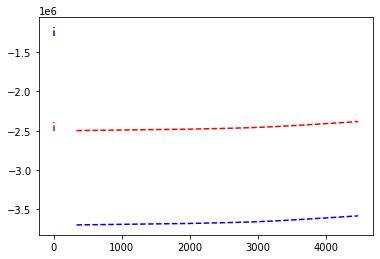

In [253]:
plt.plot(XX[:,:2], gam.predict(XX), 'r--')
plt.plot(XX[:,:2], gam.prediction_intervals(XX, width=.95), color='b', ls='--')

In [246]:
plt.scatter(X[:,0], y, facecolor='gray', edgecolors='none')
plt.title('95% prediction interval');

TypeError: '(slice(None, None, None), 0)' is an invalid key

In [437]:
from pygam import LinearGAM, s, f
from pygam.datasets import wage

X_wage, y_wage = wage(return_X_y=True)

## model
gam_wage = LinearGAM(s(0) + s(1) + f(2))
gam_wage.gridsearch(X_wage, y_wage)

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + f(2) + intercept, 
   tol=0.0001, verbose=False)

In [442]:
pd.DataFrame(X_wage)[2].value_counts()

1.0    971
3.0    685
2.0    650
4.0    426
0.0    268
Name: 2, dtype: int64

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


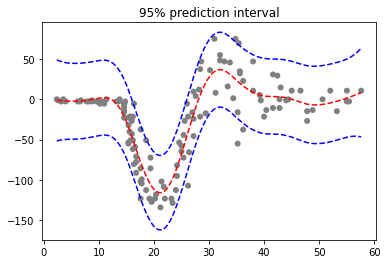

In [213]:
from pygam import LinearGAM
from pygam.datasets import mcycle

X_mcycle, y_mcycle = mcycle(return_X_y=True)

gam_mcycle = LinearGAM(n_splines=25).gridsearch(X_mcycle, y_mcycle)
XX_mcycle = gam_mcycle.generate_X_grid(term=0, n=500)

plt.plot(XX_mcycle, gam_mcycle.predict(XX_mcycle), 'r--')
plt.plot(XX_mcycle, gam_mcycle.prediction_intervals(XX_mcycle, width=.95), color='b', ls='--')

plt.scatter(X_mcycle, y_mcycle, facecolor='gray', edgecolors='none')
plt.title('95% prediction interval');

In [201]:
y_mcycle.shape

(133,)

In [200]:
X_mcycle.shape

(133, 1)

In [ ]:
# continuing last example with the mcycle dataset
for response in gam.sample(X, y, quantity='y', n_draws=50, sample_at_X=XX):
    plt.scatter(XX, response, alpha=.03, color='k')
plt.plot(XX, gam.predict(XX), 'r--')
plt.plot(XX, gam.prediction_intervals(XX, width=.95), color='b', ls='--')
plt.title('draw samples from the posterior of the coefficients')



In [ ]:
gam = LinearGAM(statement)
gam.gridsearch(X_np, y_np)